# Time Series Prediction Example

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np


plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

## Kaggle Setup

Note that kaggle must be imported after the API keys are configured.

In [2]:
def read_kaggle_json(filepath):
    filepath = os.path.expanduser(filepath)
    username = None
    token = None
    with open(filepath, "r") as file:
        config = json.load(file)
        username = config.get("username")
        token = config.get("key")
    return username, token


kaggle_json_filepath = "/workspaces/fall-2024-class-08/kaggle/kaggle.json"
kaggle_username, kaggle_api_token = read_kaggle_json(kaggle_json_filepath)

if kaggle_username and kaggle_api_token:
    os.environ["KAGGLE_USERNAME"] = kaggle_username
    os.environ["KAGGLE_KEY"] = kaggle_api_token

In [3]:
import kaggle

dataset_name = "andrewmvd/sp-500-stocks"
download_location = "/workspaces/fall-2024-class-08/downloads"

kaggle.api.authenticate()
kaggle.api.dataset_download_files(
    dataset_name, path=download_location, unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks


## Read Data

In [4]:
stocks_file_path = "/workspaces/fall-2024-class-08/downloads/sp500_stocks.csv"
stocks_df = pd.read_csv(stocks_file_path)
stocks_df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,44.016731,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,43.741028,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,44.361347,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,44.393162,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,44.705978,70.501671,70.501671,69.648827,69.974915,4073337.0


In [5]:
index_file_path = "/workspaces/fall-2024-class-08/downloads/sp500_index.csv"
index_df = pd.read_csv(index_file_path)
index_df.head()

,Date,S&P500
0,2014-10-27,1961.63
1,2014-10-28,1985.05
2,2014-10-29,1982.30
3,2014-10-30,1994.65
4,2014-10-31,2018.05


In [6]:
companies_file_path = (
    "/workspaces/fall-2024-class-08/downloads/sp500_companies.csv"
)
companies_df = pd.read_csv(companies_file_path)
companies_df.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,233.40,3548636774400,1.317810e+11,0.049,Cupertino,CA,United States,161000.0,"Apple Inc. designs, manufactures, and markets ...",0.065130
1,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,140.52,3446955573248,6.118400e+10,1.224,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.063264
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,426.59,3171457695744,1.294330e+11,0.152,Redmond,WA,United States,228000.0,Microsoft Corporation develops and supports so...,0.058208
3,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,168.34,2013312712704,1.154780e+11,0.136,Mountain View,CA,United States,179582.0,Alphabet Inc. offers various products and plat...,0.036951
4,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,166.72,2013310746624,1.154780e+11,0.136,Mountain View,CA,United States,179582.0,Alphabet Inc. offers various products and plat...,0.036951


### Get the Top Tech Stocks

In [7]:
technology_symbols_sorted_by_marketcap = companies_df[
    companies_df["Sector"] == "Technology"
].sort_values(by="Marketcap", ascending=False)["Symbol"]

top_ten_technology_symbols = technology_symbols_sorted_by_marketcap[:10]

print(top_ten_technology_symbols)

0     AAPL
1     NVDA
2     MSFT
10    AVGO
16    ORCL
26     CRM
30     AMD
32     ACN
34    CSCO
38     IBM
Name: Symbol, dtype: object


### Get the Dates Data was Acquired

In [8]:
dates = stocks_df["Date"].unique()
print(dates)
print(dates.shape)

['2010-01-04' '2010-01-05' '2010-01-06' ... '2024-10-24' '2024-10-25'
 '2024-10-28']
(3730,)


## Extract Features

In [9]:
from feature_extraction import get_features, get_targets, make_train_test_split

In [10]:
# Specify the target symbol to predict, number of days of history to use in the
# autoregressive model, and number of days forward to predict.
target_symbol = "AAPL"
n_days_history = 20
n_days_forward = 1

# Specify the list of symbols to use as features. To use the top ten tech
# stocks by market cap, use the following:
# >>> predictor_symbols = top_ten_technology_symbols.tolist()
predictor_symbols = ["AAPL"]
# predictor_symbols = top_ten_technology_symbols.tolist()

# Get the dataset
x_features = get_features(
    dates, stocks_df, n_days_history, n_days_forward, predictor_symbols
)
inference_dates, y_targets_low, y_targets_high = get_targets(
    dates, stocks_df, target_symbol, n_days_history, n_days_forward
)

# Train-test split
dates_train, dates_test = make_train_test_split(inference_dates)
x_train, x_test = make_train_test_split(x_features)
y_low_train, y_low_test = make_train_test_split(y_targets_low)
y_high_train, y_high_test = make_train_test_split(y_targets_high)

print("X array shape:", x_features.shape)
print("y_low shape:", y_targets_low.shape)
print("y_high shape:", y_targets_high.shape)
print("inference_dates shape:", inference_dates.shape)
print("x features:", x_features[n_days_forward])
print("y targets:", (y_targets_low[0], y_targets_high[0]))

X array shape: (3710, 40)
y_low shape: (3710,)
y_high shape: (3710,)
inference_dates shape: (3710,)
x features: [7.61607122 7.69964314 7.52678585 7.68678617 7.46607113 7.57142878
 7.46642923 7.57142878 7.44464302 7.60714293 7.37214279 7.491786
 7.28928614 7.53321409 7.46500015 7.51642895 7.35249996 7.55714321
 7.40142918 7.68535709 7.48214293 7.69821405 7.40035677 7.61821413
 7.04142904 7.41071415 7.14964294 7.31071377 7.23500013 7.63250017
 7.12607098 7.52071381 7.09642887 7.33928585 6.79464293 7.22142887
 6.83214283 7.         6.90642881 7.01142883]
y targets: (np.float64(6.906428813934326), np.float64(7.0114288330078125))


## Fit a Basic Regressor

In [11]:
from error_metrics import compute_rmse_pair
from regressors import fit_linear_regressor_pair, predict_linear_regressor_pair

In [12]:
low_model, high_model = fit_linear_regressor_pair(
    x_train, y_low_train, y_high_train
)

### Compute Basic Regressor Training Error

In [13]:
y_low_train_hat, y_high_train_hat = predict_linear_regressor_pair(
    low_model, high_model, x_train
)
low_rmse_train, high_rmse_train = compute_rmse_pair(
    y_low_train, y_high_train, y_low_train_hat, y_high_train_hat
)

print("Training RMSE for low value prediction:", low_rmse_train)
print("Training RMSE for high value prediction:", high_rmse_train)

Training RMSE for low value prediction: 0.8858757199551315
Training RMSE for high value prediction: 0.8209223842316233


### Compute Basic Regressor Testing Error

In [14]:
y_low_test_hat, y_high_test_hat = predict_linear_regressor_pair(
    low_model, high_model, x_test
)
low_mse_test, high_mse_test = compute_rmse_pair(
    y_low_test, y_high_test, y_low_test_hat, y_high_test_hat
)

print("Test RMSE for low value prediction:", low_mse_test)
print("Test RMSE for high value prediction:", high_mse_test)

Test RMSE for low value prediction: 2.7505493889239623
Test RMSE for high value prediction: 2.637506754873312


### Visualize the Naive Predictions

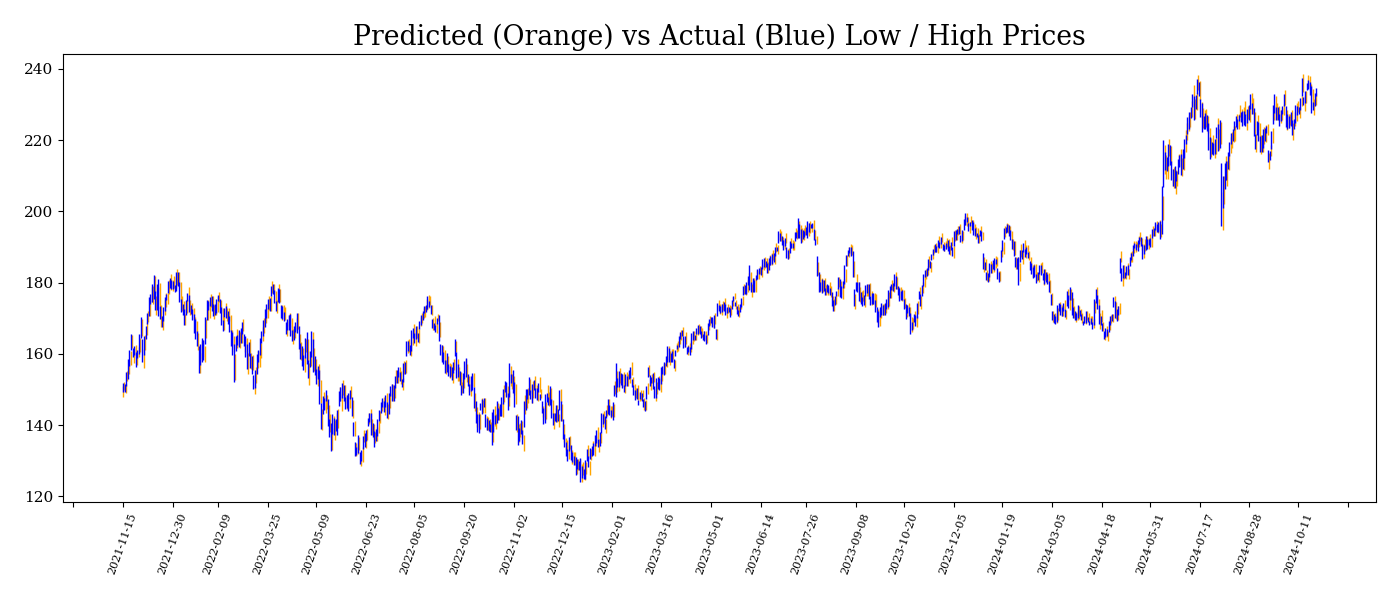

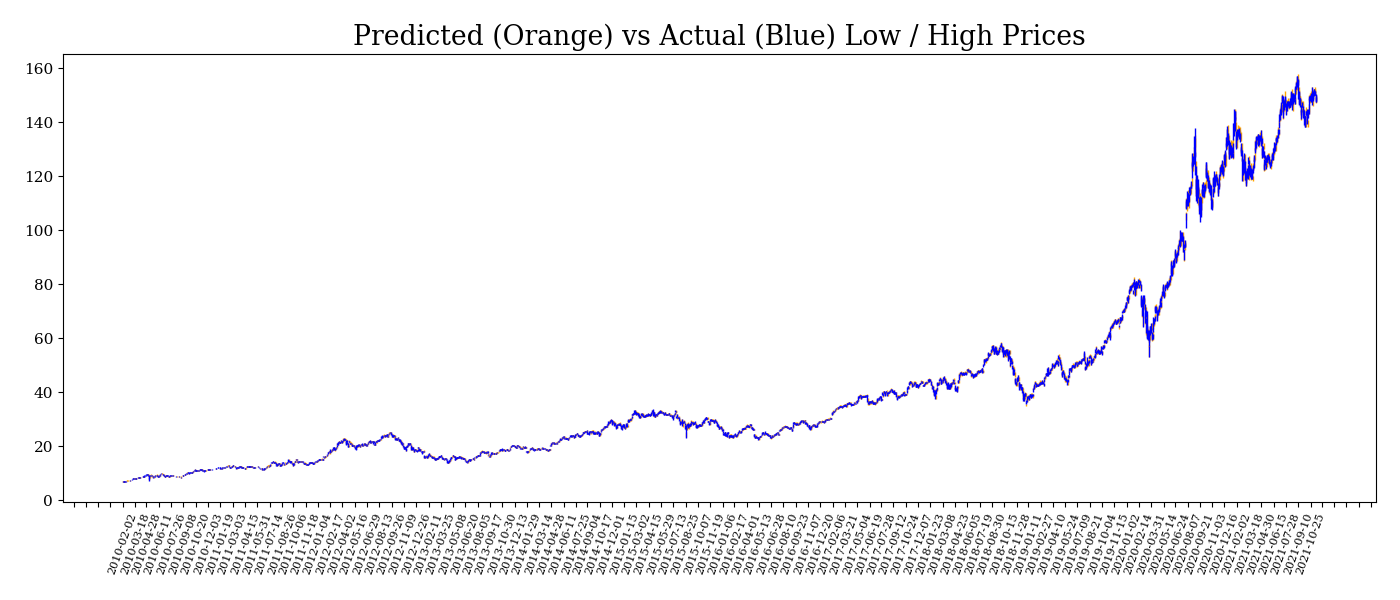

In [15]:
from visualization import plot_candlesticks

plot_candlesticks(
    dates_test, y_low_test_hat, y_high_test_hat, y_low_test, y_high_test
)
plot_candlesticks(
    dates_train, y_low_train_hat, y_high_train_hat, y_low_train, y_high_train
)

In [37]:
def compute_middle_value(y_low, y_high):
    return (y_high + y_low) / 2


cash_available = 1000
shares_held = 0
buy_shares = 1
sell_shares = 1
delta_buy_threshold = 1
delta_sell_threshold = -1

for x_test_sample, y_low_today, y_high_today in zip(
    x_test[1:], y_low_test[:-1], y_high_test[:-1]
):
    y_low_future_predicted = low_model.predict(x_test_sample.reshape(1, -1))
    y_high_future_predicted = low_model.predict(x_test_sample.reshape(1, -1))
    y_middle_future_predicted = compute_middle_value(
        y_high_future_predicted, y_low_future_predicted
    )
    y_middle_today = compute_middle_value(y_high_today, y_low_today)
    delta = y_middle_future_predicted - y_middle_today

    if delta > delta_buy_threshold:
        shares_held += buy_shares
        cash_available -= buy_shares * y_middle_today

    if delta < delta_sell_threshold:
        shares_actually_sold = np.max(0, shares_held - sell_shares)
        shares_held -= shares_actually_sold
        cash_available += shares_actually_sold * y_middle_today

share_value_held = shares_held * y_middle_today
portfolio_value = cash_available + share_value_held

print("Cash available: ", cash_available)
print("Shares held: ", shares_held)
print("Share value held:", share_value_held)
print("Portfolio value:", portfolio_value)

Cash available:  815.1699981689453
Shares held:  1
Share value held: 231.39500427246094
Portfolio value: 1046.5650024414062


In [38]:
cash_available = 1000
shares_held = 0
buy_shares = 1
sell_shares = 1
delta_buy_threshold = 1
delta_sell_threshold = -1

y_middle_day0 = compute_middle_value(y_high_test[0], y_low_test[0])
y_middle_today = compute_middle_value(y_high_test[-1], y_low_test[-1])

shares_held += buy_shares
cash_available -= buy_shares * y_middle_day0

share_value_held = shares_held * y_middle_today
portfolio_value = cash_available + share_value_held

print("Cash available: ", cash_available)
print("Shares held: ", shares_held)
print("Share value held:", share_value_held)
print("Portfolio value:", portfolio_value)

Cash available:  849.3450012207031
Shares held:  1
Share value held: 233.63999938964844
Portfolio value: 1082.9850006103516


In [34]:
y_high_today, y_low_today, y_middle_today

(np.float64(233.22000122070312),
 np.float64(229.57000732421875),
 np.float64(231.39500427246094))

In [17]:
from sklearn.decomposition import FastICA

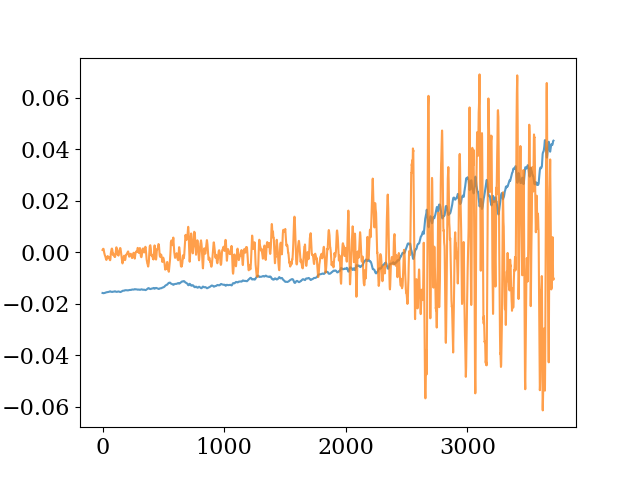

In [18]:
n_features = x_features.shape[1]

from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# x_features_scaled = scaler.fit_transform(x_features)


# This would need to be applied to each stock separately
mu = np.average(x_features)
sigma = np.std(x_features)

x_features_scaled = (x_features - mu) / sigma

ica = FastICA(
    n_components=2,
    whiten="arbitrary-variance",
    tol=1e-10,
    max_iter=500,
    random_state=42,
)
x_features_transformed = ica.fit_transform(x_features_scaled)

plt.figure()
plt.plot(x_features_transformed, alpha=0.75)

In [19]:
# TODO: Dynamically select noise component

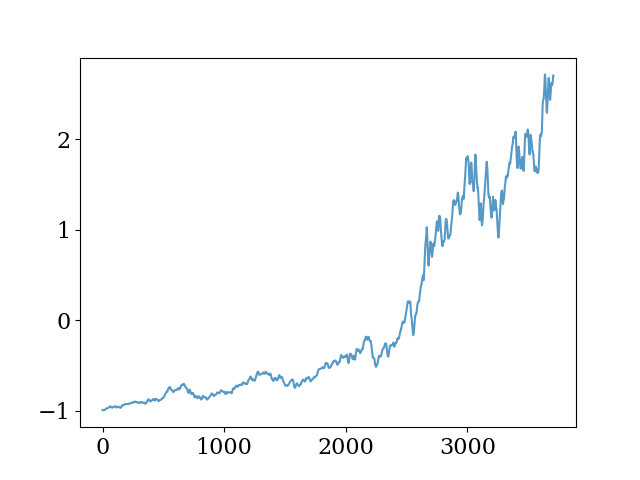

In [22]:
x_smooth = x_features_transformed[:, 0]
x_smooth_original_scale = x_smooth * sigma

plt.figure()
plt.plot(x_smooth_original_scale, alpha=0.75)
# plt.plot(x_features)